In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
from IPython.display import HTML
import time
import datetime
import json

#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import sys

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon

import seaborn as sns
from sklearn.model_selection import train_test_split

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#Set seed
SEED = 4893

np.random.seed(SEED)
rand = np.random.RandomState(SEED)
tf.random.set_seed(SEED)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Num GPUs Available:  1


In [2]:
#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..')
path_common =  '\\'.join(parent_path.split('\\')[:-1]) 

#Check if path exists
path_common_scripts = os.path.join(path_common,'Common','Scripts')
if(not os.path.exists(path_common_scripts)):
    print('The path: '+ path_common_scripts+' is not found!')
path_common = os.path.join(path_common,'Common')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ path_common+' is not found!')



#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common_scripts)

#Retrieve test specification document
test_spec_json = os.path.join(path_common,'hyper_parameters.json')
#Check if file exists
if(not os.path.exists(test_spec_json)):
    print('The file: '+ test_spec_json+' is not found!')
with open(test_spec_json) as f:
    test_spec = json.load(f)
    
params = test_spec['parameters']

model_params = params['model_parameters']

experiment_params = params['experiment_parameters']

#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))

NUM_TRAINING_ITERATIONS = experiment_params['number_of_training_iterations']
LOSS_TYPE = experiment_params['loss_type']
#BATCH_SIZE_TR = experiment_params['training_batch_size']
#BATCH_SIZE_TE = experiment_params['testing_batch_size']
#BATCH_SIZE_GE = experiment_params['generalisation_batch_size']
NUM_PROCESSING_STEPS_TR = experiment_params['number_of_processing_steps_tr']
NUM_PROCESSING_STEPS_TE = experiment_params['number_of_processing_steps_te']
NUM_PROCESSING_STEPS_GE = experiment_params['number_of_processing_steps_ge']
#ROLLOUT_TIMESTEPS = experiment_params['rollout_timesteps']
#ROLLOUT_TIMESTEPS_VIS = experiment_params['rollout_timesteps_vis']

FUL_LATENT_SIZE = model_params['ful_block_latent_size']
FUL_LAYER_NUMBER = model_params['ful_block_number_of_layers']
IND_LATENT_SIZE = model_params['ind_block_latent_size']
IND_LAYER_NUMBER = model_params['ind_block_number_of_layers']

Current_date: 2021-04-10 01:23:04.604573


In [3]:
# Import model
import GNNModels_tf2 as models
# Import training plot
from TrainingPlot import training_plot, training_plot_log_scale
# Import rollout plot
from RolloutPlot import rollout_plot, rollout_plot_log_scale
# Import functions for creating graph
from Graph_creator_functions import rigid_graph_from_pos_all, rigid_graph_from_pos_closest
# Import data loader module
from PushDatasetLoad import load_dataset, collect_trajectory_indeces, create_train_valid_test, collect_states, remove_effector, outlier_remover, dataset_formating
# Import Dataset Feeder function
from PushDatasetFeed import DataFeeder
# Import simulation functions
from PushDatasetSimulator import PushDatasetSimulator
# Import function for experiments
from LossFunctions import velocity_loss_single_step, make_all_runnable_in_session, rollout_loss_mean, rollout_loss_sum, rollout_loss_max, rollout_error
# Import visualisation functions
from VisualisationFunctions import visualise_trajectory, visualise_groundtruth

## Data loading:
In this section of the code we load the data. Split the trajectories into training, validation and testing sets.

In [4]:
#Path to Datasets
path_dataset = os.path.abspath('..\\..\\..\\..')
path_dataset = os.path.join(path_dataset,'Data')

if(not os.path.exists(path_dataset)):
    print("Data folder does not exist.")
    
# Set paths:
file_1 = os.path.join(path_dataset, "Rect1_Data50ms_1_of_2_flagged.csv")
file_2 = os.path.join(path_dataset, "Rect1_Data50ms_2_of_2_flagged.csv")
# Load dataset
df_set_1, STEP_SIZE = load_dataset(file_1)
df_set_2, STEP_SIZE = load_dataset(file_2)

# Collect trajectory indeces
VEL_ACCS = ['10.0-0.0','20.0-0.0','50.0-0.0']
trajectory_indeces,df_set_1 = collect_trajectory_indeces(df_set_1, ts = STEP_SIZE, vel_accs = VEL_ACCS)

_, df_set_2 = collect_trajectory_indeces(df_set_2, ts = STEP_SIZE, vel_accs = VEL_ACCS)
# Split indeces so that no trajectory is contained in both train, validation or test datasets
tr_inds, va_inds, te_inds = create_train_valid_test(trajectory_indeces, 0.15)

# Collect trajectories from these 
df_tr_1 = collect_states(tr_inds, df_set_1)
df_tr_2 = collect_states(tr_inds, df_set_2)
df_va_1 = collect_states(va_inds, df_set_1)
df_va_2 = collect_states(va_inds, df_set_2)
df_te_1 = collect_states(te_inds, df_set_1)
df_te_2 = collect_states(te_inds, df_set_2)

# Remove Outliers
df_tr_1, df_tr_2 = outlier_remover(df_tr_1, df_tr_2, 0.001)
df_va_1, df_va_2 = outlier_remover(df_va_1, df_va_2, 0.001)
df_te_1, df_te_2 = outlier_remover(df_te_1, df_te_2, 0.001)


min_roll_tr, max_batch_tr, df_tr_1, df_tr_2 = dataset_formating(df_tr_1,df_tr_2)
min_roll_te, max_batch_te, df_te_1, df_te_2 = dataset_formating(df_te_1,df_te_2)
min_roll_va, max_batch_va, df_va_1, df_va_2 = dataset_formating(df_va_1,df_va_2)

print("Tr","Min rollout step number: ", min_roll_tr, ", Max batch size: ",max_batch_tr)
print("Te","Min rollout step number: ", min_roll_te, ", Max batch size: ",max_batch_te)
print("Va","Min rollout step number: ", min_roll_va, ", Max batch size: ",max_batch_va)

BATCH_SIZE_TR = int(max_batch_tr / 4)
BATCH_SIZE_GE = int(max_batch_va) 
BATCH_SIZE_TE = int(max_batch_te)

ROLLOUT_TIMESTEPS = int(min(min_roll_tr,min_roll_te, min_roll_va) / 4)

df_dict = {"tr_1":df_tr_1, 
           "tr_2":df_tr_2, 
           "va_1":df_va_1,
           "va_2":df_va_2,
           "te_1":df_te_1,
           "te_2":df_te_2,}

Tr Min rollout step number:  50.0 , Max batch size:  265
Te Min rollout step number:  58.0 , Max batch size:  23
Va Min rollout step number:  80.0 , Max batch size:  26


In [5]:
# Folder description to distinguish between experiment runs
desc = "ntr="+str(NUM_TRAINING_ITERATIONS)
desc = desc +"_step="+str(STEP_SIZE)
desc = desc +"_size_tr_batch="+str(BATCH_SIZE_TR)
desc = desc +"_n_rollout="+str(ROLLOUT_TIMESTEPS)
desc = desc +"_date="+str(current_time)
desc = desc +"_seed="+str(SEED)

In [6]:
# Setup folders
base = os.getcwd()
if(not os.path.exists(base)):
    os.makedirs(base)
    
#Path to saved models and trajectories
path_saves = os.path.join(base,desc,'Saves')
if(not os.path.exists(path_saves)):
    os.makedirs(path_saves)
    
#Path to plots
path_plots = os.path.join(base,desc,'Plots')
if(not os.path.exists(path_plots)):
    os.makedirs(path_plots)
    
#Path to animations
path_animations = os.path.join(base,desc,'Animations')
if(not os.path.exists(path_animations)):
    os.makedirs(path_animations)
    
#Save the used parameters as a json file into this folder
with open(os.path.join(path_saves,'specification.json'), 'w') as fp:
    json.dump(test_spec, fp)

# Train

In [7]:
# Create the model.
model = models.EncodeProcessDecode(ind_layer_numbers = IND_LAYER_NUMBER,
                                   ind_latent_unit_size = IND_LATENT_SIZE,
                                   ful_layer_numbers = FUL_LAYER_NUMBER,
                                   ful_latent_unit_size = FUL_LATENT_SIZE,
                                   node_output_size=2,
                                   edge_output_size=2,
                                   global_output_size=1)



LEARNING_RATE = model_params['learning_rate']
optimizer = snt.optimizers.Adam(0.0002)

In [8]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, os.path.join(path_saves,'tf_ckpts'), max_to_keep=3)

In [9]:
def update_step(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, 1)
        # Only Nodes
        outputs_tr_nodes = outputs_tr[0].nodes
        targets_tr_nodes = targets_tr.nodes
        # Loss
        loss_tr = velocity_loss_single_step(targets_tr, outputs_tr[0])
    
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_tr, gradients

def test_step(inputs, targets):
    outputs = model(inputs, 1)
    # Only Nodes
    output_nodes = outputs[0].nodes
    target_nodes = targets.nodes
    
    # Loss
    loss = velocity_loss_single_step(targets, outputs[0])
    
    return loss


def update_step_rollout(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        # Predict trajectory using the model
        pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, inputs_tr, targets_tr)
        # Loss tr
        loss_tr = rollout_loss_sum(real_trajectory, pred_trajectory)
        
    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return 0, loss_tr, gradients

def test_step_rollout(inputs, targets):
    # Predict trajectory using the model
    pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, inputs, targets)
    
    # Loss
    loss = rollout_loss_sum(real_trajectory, pred_trajectory)
                        
    return loss


## Compiling loss function

In [10]:
# Setup data feeder and simulator

# One step data feeder
feeder = DataFeeder(SEED)
d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all)

# Rollout simulator feeder
sim = PushDatasetSimulator(rollout_steps = ROLLOUT_TIMESTEPS, 
                           step_size = STEP_SIZE)
# ------------------------------------------------------------------------

# Get data from feeder
X_tr_step = d["X_tr"]
Y_tr_step = d["Y_tr"]

# Get data from simulator
real, pred, i_np = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
X_tr_roll, Y_tr_roll = sim.convert_trajectories(real, pred)

# ------------------------------------------------------------------------

# Get input signature of one step input
input_signature_step = [
    utils_tf.specs_from_graphs_tuple(X_tr_step),
    utils_tf.specs_from_graphs_tuple(X_tr_step)]

# Get input signature of rollout input
input_signature_rollout = [
    [utils_tf.specs_from_graphs_tuple(X_tr_roll[0])]*ROLLOUT_TIMESTEPS,
    [utils_tf.specs_from_graphs_tuple(Y_tr_roll[0])]*ROLLOUT_TIMESTEPS]

# ------------------------------------------------------------------------

# Compile the update function using the input signature for speedy code
compiled_update_step = tf.function(update_step, input_signature = input_signature_step)
compiled_update_step_rollout = tf.function(update_step_rollout, input_signature = input_signature_rollout)

In [11]:
tf.config.run_functions_eagerly(False)
# Setup logging
last_iteration = 0
logged_iterations = []
losses_step_tr = []
losses_step_va = []
losses_step_te = []

losses_roll_tr = []
losses_roll_va = []
losses_roll_te = []
gradients = []

log_every_iteration = 5

print("# (iteration number) out of max iteration, T (elapsed seconds), "
      "Ltr, "
      "Lte, "
      "Lge")

start_time = time.time()
last_log_time = start_time


best_loss = 1000
 
for iteration in range(last_iteration, NUM_TRAINING_ITERATIONS):
    last_iteration = iteration
    do_logging = (last_iteration % log_every_iteration == 0)
    
    loss_roll_tr = tf.constant([0])
    loss_step_tr = tf.constant([0])
    gradient = tf.constant([0])
    
    if LOSS_TYPE == "rollout":
        # Get training data: Rollout
        real_tr, pred_tr, i_np = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
        X_roll_tr, Y_roll_tr = sim.convert_trajectories(real_tr, pred_tr)

        X_step_tr = X_roll_tr[0]
        Y_step_tr = Y_roll_tr[0]   
        # Training:  One-step
        loss_step_tr = test_step(X_step_tr, Y_step_tr)
        # Do one tick of training    
        outputs_tr, loss_roll_tr, gradient = compiled_update_step_rollout(X_roll_tr, Y_roll_tr)
        
    elif LOSS_TYPE == "step":
        d = feeder.get_data(dfs = df_dict,
                    tr_batch_size = BATCH_SIZE_TR,
                    va_batch_size = BATCH_SIZE_GE,
                    te_batch_size = BATCH_SIZE_TE,
                    graph_creator = rigid_graph_from_pos_all,
                    te_and_va = False)
        
        # Get data from feeder
        X_step_tr = d["X_tr"]
        Y_step_tr = d["Y_tr"]

        # Do one tick of training    
        outputs_tr, loss_step_tr, gradient = compiled_update_step(X_step_tr, Y_step_tr)
        
    else:
        # Get training data: Rollout
        real_tr, pred_tr, i_np = sim.get_trajectories(df_tr_1, df_tr_2, BATCH_SIZE_TR, rigid_graph_from_pos_all)
        X_roll_tr, Y_roll_tr = sim.convert_trajectories(real_tr, pred_tr)

        X_step_tr = X_roll_tr[0]
        Y_step_tr = Y_roll_tr[0]   
        # Training:  Rollout
        loss_roll_tr = test_step_rollout(X_roll_tr, Y_roll_tr)
        # Do one tick of training    
        outputs_tr, loss_step_tr, gradient = compiled_update_step(X_step_tr, Y_step_tr)
    
    
    ckpt.step.assign_add(1)
    # Don't log at every iteration
    if do_logging:
        # Get validation and test data: Rollout
        real_va, pred_va, _ = sim.get_trajectories(df_va_1, df_va_2, BATCH_SIZE_GE, rigid_graph_from_pos_all)
        X_roll_va, Y_roll_va = sim.convert_trajectories(real_va, pred_va)
        real_te, pred_te, _ = sim.get_trajectories(df_te_1, df_te_2, BATCH_SIZE_TE, rigid_graph_from_pos_all)
        X_roll_te, Y_roll_te = sim.convert_trajectories(real_te, pred_te)
        
        # Get validation and test data: One-step
        X_step_va = X_roll_va[0]
        Y_step_va = Y_roll_va[0]
        X_step_te = X_roll_te[0]
        Y_step_te = Y_roll_te[0]      
        
        # Validation and Test: Rollout
        loss_roll_va = test_step_rollout(X_roll_va, Y_roll_va)
        loss_roll_te = test_step_rollout(X_roll_te, Y_roll_te)
        
        # Validation and Test: One-step
        loss_step_va = test_step(X_step_va, Y_step_va)
        loss_step_te = test_step(X_step_te, Y_step_te)
        
        # Convert losses to normal values
        loss_roll_tr = loss_roll_tr[0].numpy()
        loss_roll_va = loss_roll_va[0].numpy()
        loss_roll_te = loss_roll_te[0].numpy()
        loss_step_tr = loss_step_tr[0].numpy()
        loss_step_va = loss_step_va[0].numpy()
        loss_step_te = loss_step_te[0].numpy()
        
        the_time = time.time()
        elapsed_since_last_log = the_time - last_log_time
        last_log_time = the_time
        
        # Save
        if best_loss > loss_roll_va:
            save_path = manager.save()
            print("Saved checkpoint for step {}".format(int(ckpt.step)))
            best_loss = loss_roll_va.copy()
        
        # Log data
        elapsed = time.time() - start_time
        losses_roll_tr.append(loss_roll_tr)
        losses_roll_va.append(loss_roll_va)
        losses_roll_te.append(loss_roll_te)
        
        losses_step_tr.append(loss_step_tr)
        losses_step_va.append(loss_step_va)
        losses_step_te.append(loss_step_te)
        
        gradients.append(gradient)
        logged_iterations.append(iteration)
        
        
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr Step {:.6f}, Lva Step {:.6f}, Lte Step {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_step_tr, loss_step_va, loss_step_te))
        print("# {:05d}, Max {:05d}, T {:.1f}, Ltr Roll {:.6f}, Lva Roll {:.6f}, Lte Roll {:.6f}".format(
            iteration, NUM_TRAINING_ITERATIONS, elapsed, loss_roll_tr, loss_roll_va, loss_roll_te))
        print("-----------------------------------------------------------------------------------")
    
tf.config.run_functions_eagerly(True)    

# (iteration number) out of max iteration, T (elapsed seconds), Ltr, Lte, Lge


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/EncodeProcessDecode/Processor/graph_network/edge_block/broadcast_receiver_nodes_to_edges/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodePr

Saved checkpoint for step 2
# 00000, Max 01000, T 12.2, Ltr Step 2.761188, Lva Step 3.374942, Lte Step 3.504107
# 00000, Max 01000, T 12.2, Ltr Roll 0.000000, Lva Roll 35.851540, Lte Roll 35.492905
-----------------------------------------------------------------------------------
Saved checkpoint for step 7
# 00005, Max 01000, T 14.6, Ltr Step 0.073514, Lva Step 0.027436, Lte Step 0.028434
# 00005, Max 01000, T 14.6, Ltr Roll 0.000000, Lva Roll 0.068901, Lte Roll 0.065386
-----------------------------------------------------------------------------------
# 00010, Max 01000, T 16.8, Ltr Step 0.011033, Lva Step 0.026624, Lte Step 0.024591
# 00010, Max 01000, T 16.8, Ltr Roll 0.000000, Lva Roll 0.183602, Lte Roll 0.163458
-----------------------------------------------------------------------------------
# 00015, Max 01000, T 19.2, Ltr Step 0.014058, Lva Step 0.009810, Lte Step 0.009514
# 00015, Max 01000, T 19.2, Ltr Roll 0.000000, Lva Roll 0.072331, Lte Roll 0.072185
------------------

# 00160, Max 01000, T 85.0, Ltr Step 0.000065, Lva Step 0.000067, Lte Step 0.000079
# 00160, Max 01000, T 85.0, Ltr Roll 0.000000, Lva Roll 0.000785, Lte Roll 0.000887
-----------------------------------------------------------------------------------
# 00165, Max 01000, T 87.1, Ltr Step 0.000069, Lva Step 0.000064, Lte Step 0.000080
# 00165, Max 01000, T 87.1, Ltr Roll 0.000000, Lva Roll 0.000688, Lte Roll 0.000781
-----------------------------------------------------------------------------------
# 00170, Max 01000, T 89.3, Ltr Step 0.000068, Lva Step 0.000076, Lte Step 0.000075
# 00170, Max 01000, T 89.3, Ltr Roll 0.000000, Lva Roll 0.000713, Lte Roll 0.000880
-----------------------------------------------------------------------------------
# 00175, Max 01000, T 91.4, Ltr Step 0.000048, Lva Step 0.000086, Lte Step 0.000056
# 00175, Max 01000, T 91.4, Ltr Roll 0.000000, Lva Roll 0.000991, Lte Roll 0.000619
----------------------------------------------------------------------------

# 00325, Max 01000, T 156.9, Ltr Step 0.000031, Lva Step 0.000044, Lte Step 0.000042
# 00325, Max 01000, T 156.9, Ltr Roll 0.000000, Lva Roll 0.000854, Lte Roll 0.000755
-----------------------------------------------------------------------------------
# 00330, Max 01000, T 159.0, Ltr Step 0.000032, Lva Step 0.000036, Lte Step 0.000042
# 00330, Max 01000, T 159.0, Ltr Roll 0.000000, Lva Roll 0.000689, Lte Roll 0.000981
-----------------------------------------------------------------------------------
# 00335, Max 01000, T 161.1, Ltr Step 0.000042, Lva Step 0.000043, Lte Step 0.000066
# 00335, Max 01000, T 161.1, Ltr Roll 0.000000, Lva Roll 0.000795, Lte Roll 0.001158
-----------------------------------------------------------------------------------
# 00340, Max 01000, T 163.7, Ltr Step 0.000030, Lva Step 0.000060, Lte Step 0.000051
# 00340, Max 01000, T 163.7, Ltr Roll 0.000000, Lva Roll 0.001151, Lte Roll 0.000916
--------------------------------------------------------------------

# 00490, Max 01000, T 229.1, Ltr Step 0.000021, Lva Step 0.000020, Lte Step 0.000024
# 00490, Max 01000, T 229.1, Ltr Roll 0.000000, Lva Roll 0.000604, Lte Roll 0.000938
-----------------------------------------------------------------------------------
# 00495, Max 01000, T 231.3, Ltr Step 0.000023, Lva Step 0.000024, Lte Step 0.000030
# 00495, Max 01000, T 231.3, Ltr Roll 0.000000, Lva Roll 0.000814, Lte Roll 0.000964
-----------------------------------------------------------------------------------
# 00500, Max 01000, T 233.4, Ltr Step 0.000020, Lva Step 0.000022, Lte Step 0.000019
# 00500, Max 01000, T 233.4, Ltr Roll 0.000000, Lva Roll 0.000623, Lte Roll 0.000791
-----------------------------------------------------------------------------------
# 00505, Max 01000, T 235.6, Ltr Step 0.000018, Lva Step 0.000033, Lte Step 0.000026
# 00505, Max 01000, T 235.6, Ltr Roll 0.000000, Lva Roll 0.001506, Lte Roll 0.001182
--------------------------------------------------------------------

# 00655, Max 01000, T 299.8, Ltr Step 0.000025, Lva Step 0.000015, Lte Step 0.000016
# 00655, Max 01000, T 299.8, Ltr Roll 0.000000, Lva Roll 0.001570, Lte Roll 0.002403
-----------------------------------------------------------------------------------
# 00660, Max 01000, T 301.9, Ltr Step 0.000016, Lva Step 0.000011, Lte Step 0.000014
# 00660, Max 01000, T 301.9, Ltr Roll 0.000000, Lva Roll 0.001405, Lte Roll 0.000719
-----------------------------------------------------------------------------------
# 00665, Max 01000, T 304.0, Ltr Step 0.000021, Lva Step 0.000024, Lte Step 0.000014
# 00665, Max 01000, T 304.0, Ltr Roll 0.000000, Lva Roll 0.002102, Lte Roll 0.001523
-----------------------------------------------------------------------------------
# 00670, Max 01000, T 306.0, Ltr Step 0.000014, Lva Step 0.000014, Lte Step 0.000013
# 00670, Max 01000, T 306.0, Ltr Roll 0.000000, Lva Roll 0.000898, Lte Roll 0.000716
--------------------------------------------------------------------

# 00820, Max 01000, T 367.9, Ltr Step 0.000024, Lva Step 0.000036, Lte Step 0.000023
# 00820, Max 01000, T 367.9, Ltr Roll 0.000000, Lva Roll 0.002575, Lte Roll 0.004222
-----------------------------------------------------------------------------------
# 00825, Max 01000, T 370.0, Ltr Step 0.000025, Lva Step 0.000054, Lte Step 0.000025
# 00825, Max 01000, T 370.0, Ltr Roll 0.000000, Lva Roll 0.002584, Lte Roll 0.002396
-----------------------------------------------------------------------------------
# 00830, Max 01000, T 372.0, Ltr Step 0.000010, Lva Step 0.000017, Lte Step 0.000009
# 00830, Max 01000, T 372.0, Ltr Roll 0.000000, Lva Roll 0.002276, Lte Roll 0.001215
-----------------------------------------------------------------------------------
# 00835, Max 01000, T 374.1, Ltr Step 0.000078, Lva Step 0.000111, Lte Step 0.000093
# 00835, Max 01000, T 374.1, Ltr Roll 0.000000, Lva Roll 0.008725, Lte Roll 0.007490
--------------------------------------------------------------------

# 00985, Max 01000, T 435.7, Ltr Step 0.000023, Lva Step 0.000014, Lte Step 0.000013
# 00985, Max 01000, T 435.7, Ltr Roll 0.000000, Lva Roll 0.000875, Lte Roll 0.000742
-----------------------------------------------------------------------------------
# 00990, Max 01000, T 437.8, Ltr Step 0.000188, Lva Step 0.000203, Lte Step 0.000237
# 00990, Max 01000, T 437.8, Ltr Roll 0.000000, Lva Roll 0.010092, Lte Roll 0.010369
-----------------------------------------------------------------------------------
# 00995, Max 01000, T 439.8, Ltr Step 0.000142, Lva Step 0.000100, Lte Step 0.000079
# 00995, Max 01000, T 439.8, Ltr Roll 0.000000, Lva Roll 0.007399, Lte Roll 0.008610
-----------------------------------------------------------------------------------


## Restore best model

In [12]:
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from C:\Users\vbenc\Projects\Honours\Honours3\Phases\Phase3\Tool - Quantitative Rollout Plot\ntr=1000_step=0.05_size_tr_batch=66_n_rollout=12_date=041021_seed=4893\Saves\tf_ckpts\ckpt-13


## Saving losses

In [13]:
def save_data(name, data):
    data = np.array(data)
    if os.path.exists(os.path.join(path_saves, name)):
        print("The file: "+ name + " already exists. Delete it before saving a new trajectory!")
    else:
        if not os.path.exists(os.path.join(path_saves)):
            os.makedirs(os.path.join(path_saves)) 
            
        np.save(os.path.join(path_saves, name), data)

save_data("iterations", logged_iterations)
save_data("losses_step_tr", losses_step_tr)
save_data("losses_step_te", losses_step_te)
save_data("losses_step_va", losses_step_va)
save_data("losses_roll_tr", losses_roll_tr)
save_data("losses_roll_te", losses_roll_te)
save_data("losses_roll_va", losses_roll_va)
save_data("gradients", gradients)


C:\Users\vbenc\miniconda3\envs\Honours\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


<IPython.core.display.Javascript object>


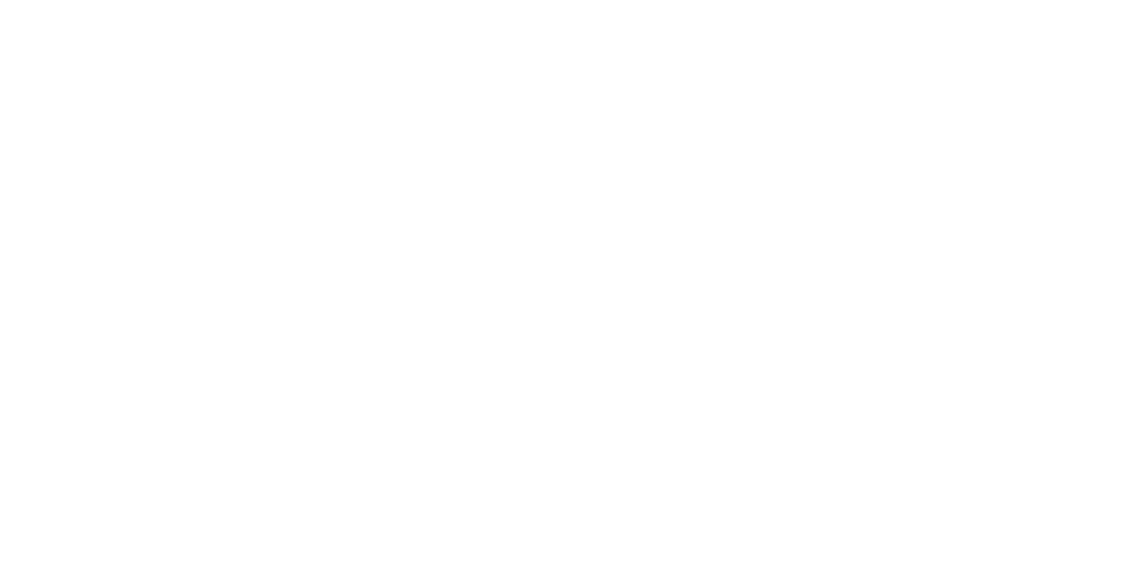

In [14]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots, "StepConvergencePlot")
plt.show()

<IPython.core.display.Javascript object>


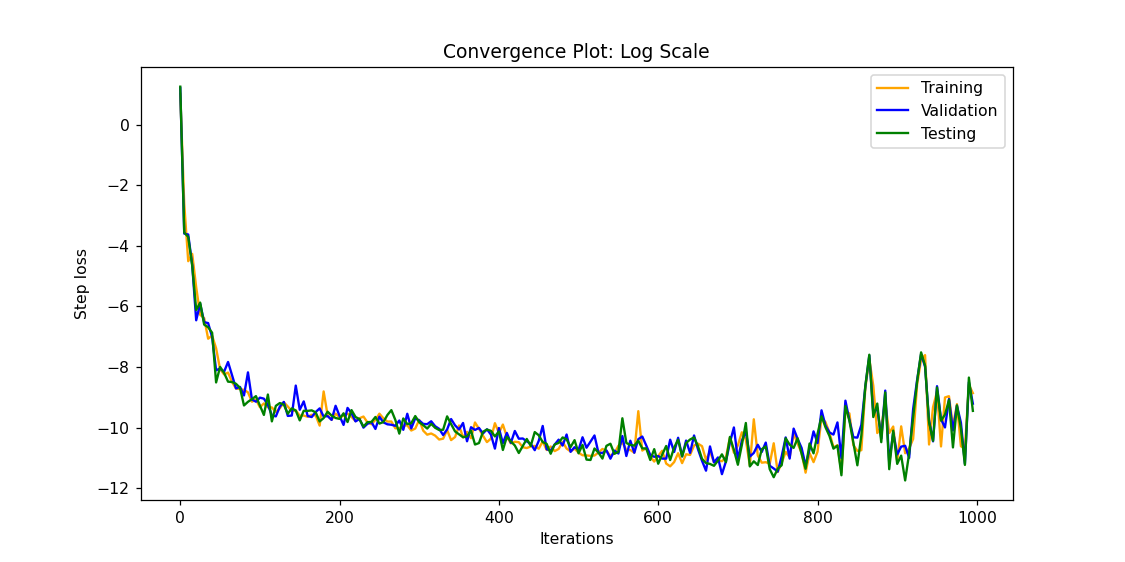

In [15]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_step_tr, losses_step_va, losses_step_te, path_plots, "StepConvergencePlotLogScale")
plt.show()

<IPython.core.display.Javascript object>


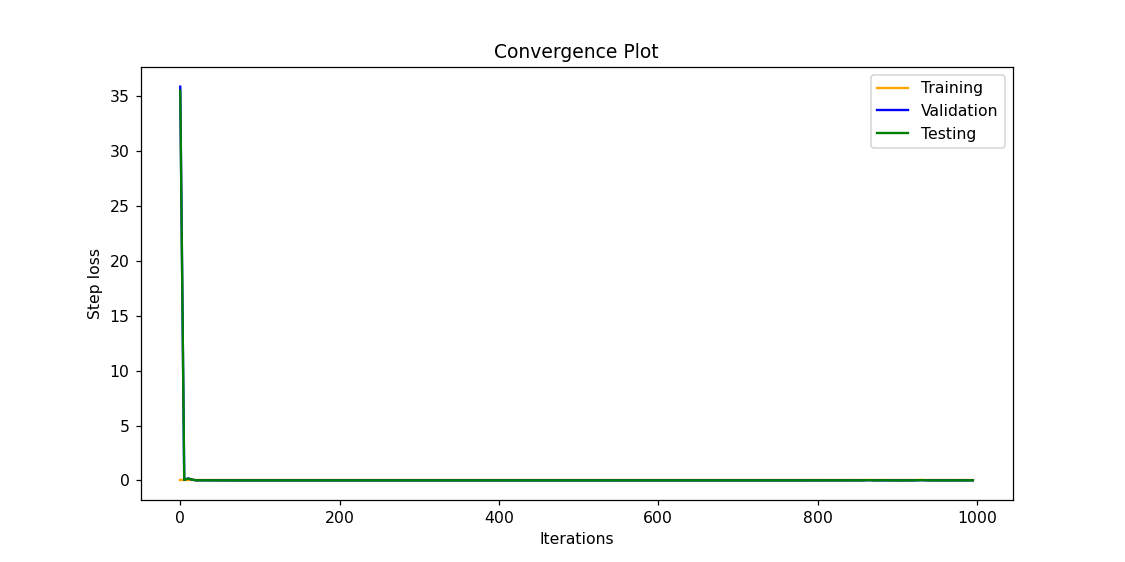

In [16]:
plt.close('all')
fig, ax = training_plot(logged_iterations, losses_roll_tr, losses_roll_va, losses_roll_te, path_plots, "RolloutConvergencePlot")
plt.show()

<IPython.core.display.Javascript object>


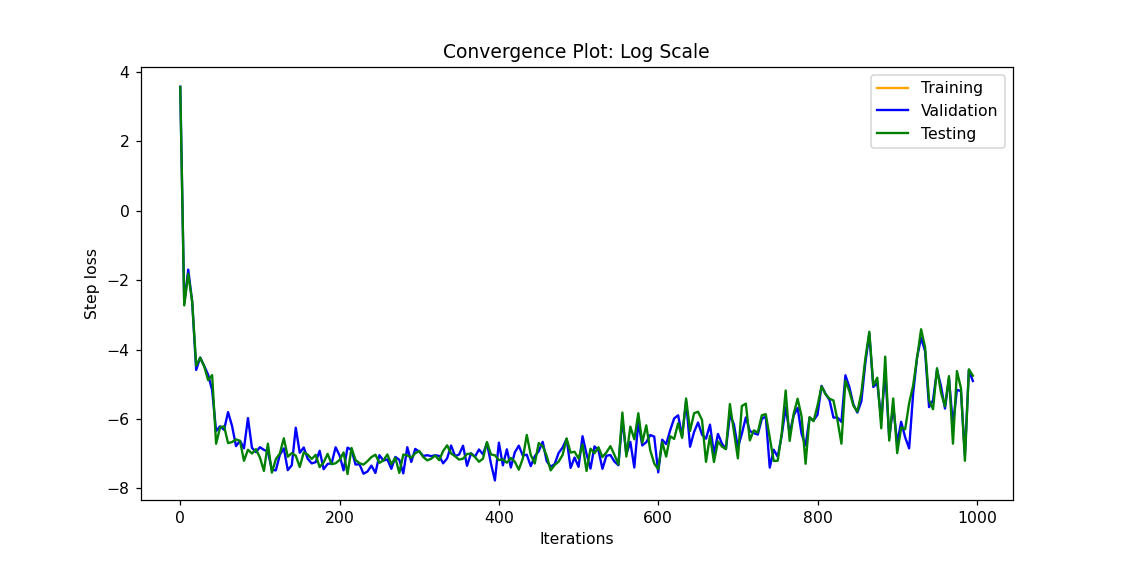

C:\Users\vbenc\Projects\Honours\Honours3\Phases\Common\Scripts\TrainingPlot.py:62: RuntimeWarning: divide by zero encountered in log
  y = np.log(tr_loss)


In [17]:
plt.close('all')
fig, ax = training_plot_log_scale(logged_iterations, losses_roll_tr, losses_roll_va, losses_roll_te, path_plots, "RolloutConvergencePlotLogScale")
plt.show()

## Evaluation

In [37]:
# Simulator
sim = PushDatasetSimulator(rollout_steps = ROLLOUT_TIMESTEPS, 
                           step_size = STEP_SIZE)

X_g, Y_g, i_np = sim.get_trajectories(df_te_1, df_te_2, 1, rigid_graph_from_pos_all)
# Convert trajectories into graphs
traj_X, traj_Y = sim.convert_trajectories(X_g,Y_g)
# Predict trajectory using the model
pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, traj_X, traj_Y)
# Get error in rollout
steps, error = rollout_error(real_trajectory, pred_trajectory)
error = error + 0.000002

<IPython.core.display.Javascript object>


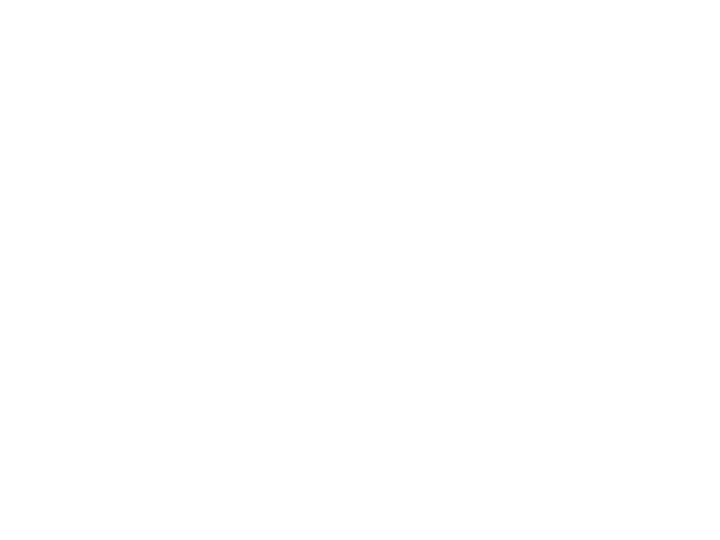

In [38]:
plt.close('all')
fig, ax, anim = visualise_trajectory(pred_trajectory, real_trajectory, ROLLOUT_TIMESTEPS)
anim.save(os.path.join(path_animations,'visualisation.gif'), writer='imagemagick', fps=60)
plt.close('all')
HTML(anim.to_jshtml())

In [39]:
# Simulator
sim = PushDatasetSimulator(rollout_steps = ROLLOUT_TIMESTEPS, 
                           step_size = STEP_SIZE)

X_g, Y_g, i_np = sim.get_trajectories(df_te_1, df_te_2, BATCH_SIZE_TE, rigid_graph_from_pos_all)
# Convert trajectories into graphs
traj_X, traj_Y = sim.convert_trajectories(X_g,Y_g)
# Predict trajectory using the model
pred_trajectory, real_trajectory = sim.predict_trajectory_velocity(model, traj_X, traj_Y)
# Get error in rollout
steps, error = rollout_error(real_trajectory, pred_trajectory)
error = error + 0.000002

<IPython.core.display.Javascript object>


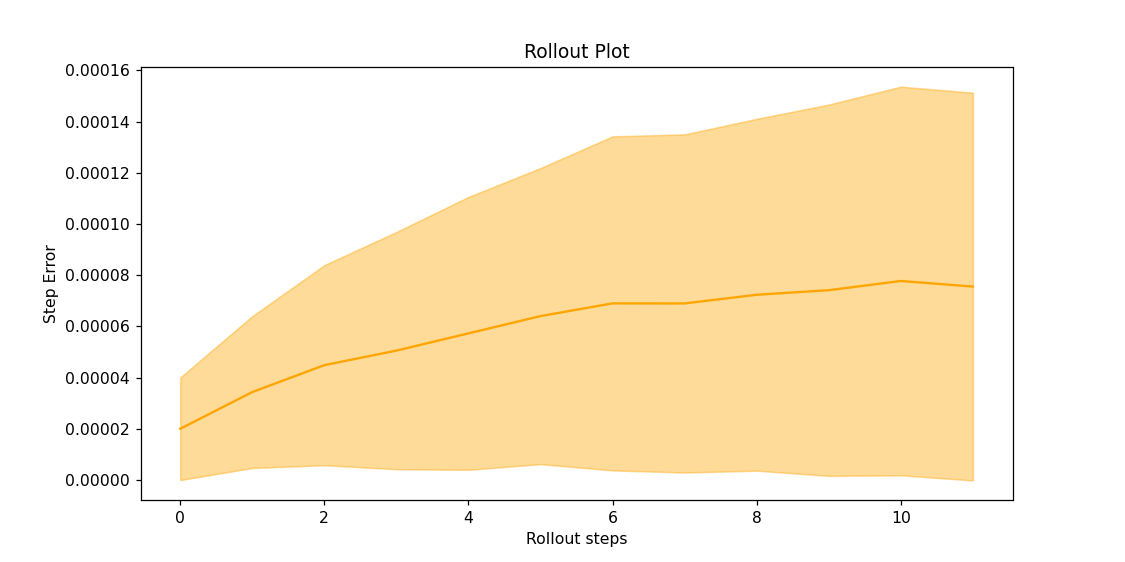

The file: RolloutPlot.png already exists. Delete it before saving a new plot!


In [40]:
plt.close('all')
fig, ax = rollout_plot(steps, error, path_plots)
plt.show()

<IPython.core.display.Javascript object>


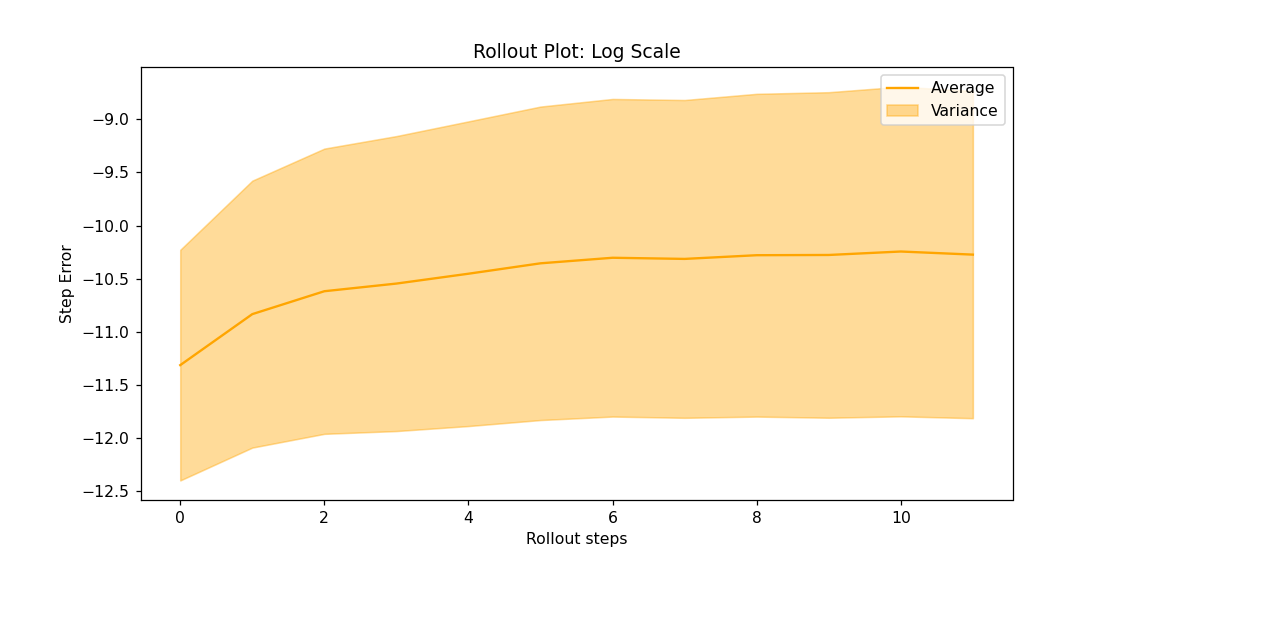

The file: RolloutPlotLogScale.png already exists. Delete it before saving a new plot!


In [41]:
plt.close('all')
fig, ax = rollout_plot_log_scale(steps, error, path_plots)
plt.show()